In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import xgboost as xg


In [150]:
filepath = os.path.join(os.getcwd(), 'df.csv')


In [151]:
df = pd.read_csv(filepath)

In [152]:
df.head(10)

,stadium,birthdate,date1,time1,distance1,trap1,comment1,date2,distance2,trap2,time2
0,Central Park,2018-12-01,2020-12-07,17.13,265,5,"slow away, middle to wide",2020-12-15,265,6,17.09
1,Central Park,2018-12-01,2020-12-15,17.09,265,6,"wide, led half",2020-12-22,265,6,16.81
2,Central Park,2018-12-01,2020-12-22,16.81,265,6,"wide, missed trouble and led first",2021-01-12,265,6,17.32
3,Central Park,2018-12-01,2021-01-12,17.32,265,6,"badly crowded half, badly baulked second",2021-01-19,265,6,17.10
4,Central Park,2018-12-01,2021-01-19,17.10,265,6,"wide, challenged run in",2021-01-27,265,6,16.84
5,Central Park,2018-12-01,2021-01-27,16.84,265,6,"quick away, wide, challenged near line",2021-02-03,265,6,16.93
6,Central Park,2018-12-01,2021-05-19,17.36,265,5,very wide first,2021-05-27,265,6,17.08
7,Central Park,2018-12-01,2021-05-27,17.08,265,6,"early pace, middle to wide, led near line",2021-06-08,265,6,16.66
8,Central Park,2018-12-01,2021-06-08,16.66,265,6,"early pace, wide, soon led",2021-06-15,265,6,17.07
9,Central Park,2018-12-01,2021-06-15,17.07,265,6,"early pace, wide, every chance",2021-06-28,265,5,17.17


In [153]:
df.shape

(533228, 11)

In [154]:
df.isnull().sum()


stadium        0
birthdate      0
date1          0
time1          0
distance1      0
trap1          0
comment1     213
date2          0
distance2      0
trap2          0
time2          0
dtype: int64

In [155]:
df.dtypes

stadium       object
birthdate     object
date1         object
time1        float64
distance1      int64
trap1          int64
comment1      object
date2         object
distance2      int64
trap2          int64
time2        float64
dtype: object

In [156]:
df = df.drop(columns = ["comment1"])
df.columns

Index(['stadium', 'birthdate', 'date1', 'time1', 'distance1', 'trap1', 'date2',
       'distance2', 'trap2', 'time2'],
      dtype='object')

In [157]:
df = pd.get_dummies(df, prefix = "stadium_", columns = ["stadium"])

In [158]:
df['birthdate'] = pd.to_datetime(df['birthdate'])
df['date1'] = pd.to_datetime(df['date1'])
df['date2'] = pd.to_datetime(df['date2'])

In [159]:
df["day_age_1"] = (df['date1'] - df['birthdate']).dt.days
df["day_age_2"] = (df['date2'] - df['birthdate']).dt.days
df["days_between_race"] = (df['date2'] - df['date1']).dt.days

df = df.drop(columns = ["birthdate", "date1", "date2"])

In [160]:
# df["velocity1"] = df["distance1"] / df["time1"]

In [161]:
# sns.pairplot(df.select_dtypes(exclude=['bool']), kind = "scatter", diag_kind = "hist", plot_kws = {'alpha': 0.5})

<Axes: >

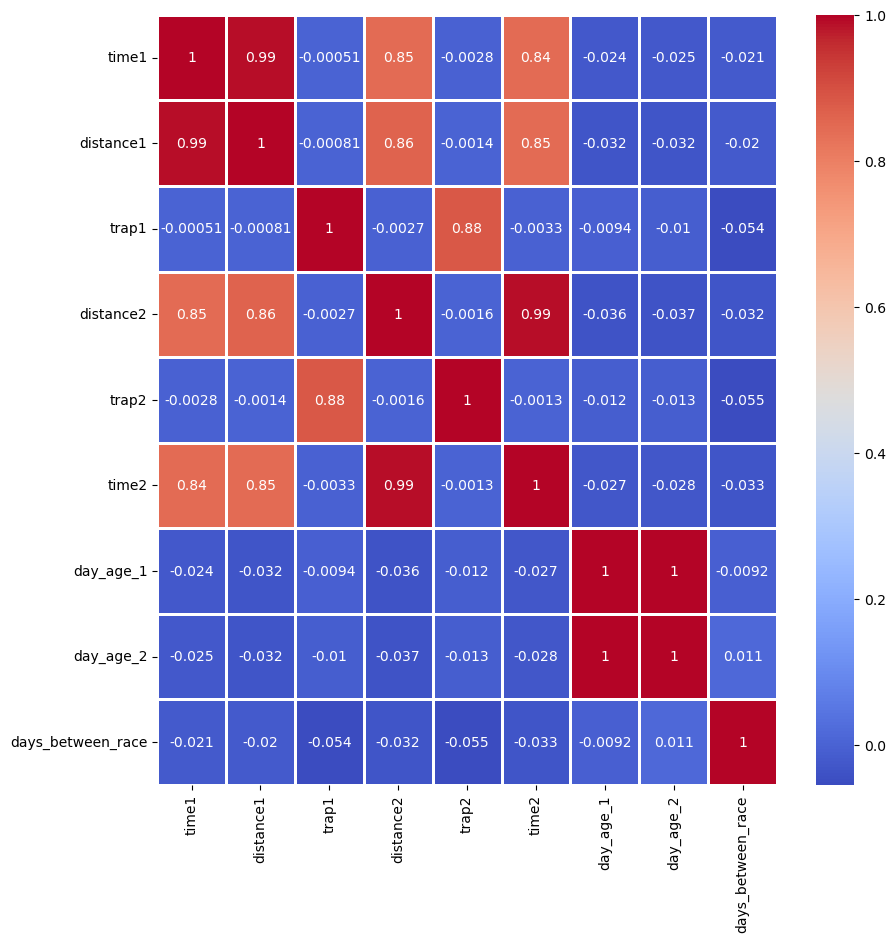

In [162]:
fig = plt.figure(figsize = (10, 10))
sns.heatmap(df.select_dtypes(exclude="bool").corr(), annot = True, cmap = 'coolwarm', linewidths=1)

# IMPLEMENT MODELS

In [163]:
y = df["time2"]
X = df.drop(columns =["time2"])


X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, random_state = 42)


In [164]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Linear Regression**

In [165]:
lin_reg = linear_model.LinearRegression()

In [166]:
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [167]:
y_pred = lin_reg.predict(X_test_scaled)

Text(0, 0.5, 'Y pred')

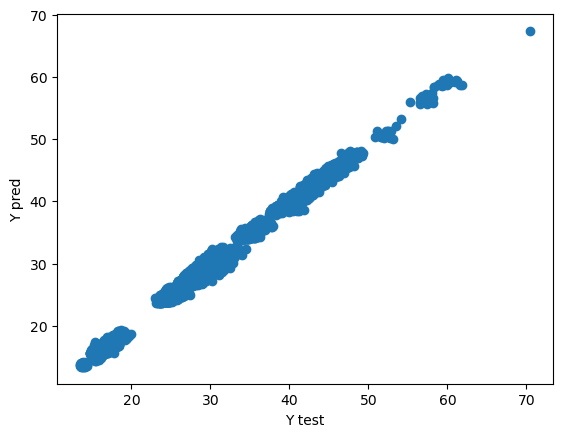

In [168]:
plt.scatter(y_test, y_pred)
plt.xlabel("Y test")
plt.ylabel("Y pred")

In [169]:
print(f"Mean square error: {mean_squared_error(y_test, y_pred)}")
print(f"Root Mean square error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Mean square error: 0.16208485732319108
Root Mean square error: 0.40259763700646717


In [203]:
xgb_r = xg.XGBRegressor( objective ='reg:squarederror', n_estimators = 200, eta = 0.17)

In [204]:
xgb_r.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.17, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [205]:
y_pred = xgb_r.predict(X_test_scaled)

In [206]:
print(f"Mean square error: {mean_squared_error(y_test, y_pred)}")

Mean square error: 0.14897216839010916


**Random Forest**

In [174]:
rand_forest = RandomForestRegressor(n_estimators= 100)
rand_forest.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [23]:
y_pred = rand_forest.predict(X_test_scaled)

In [24]:
print(f"Mean square error: {mean_squared_error(y_test, y_pred)}")

Mean square error: 0.16235179146800943


**Neural Network**

In [29]:
nn_model = keras.Sequential()

#construct input layer
input_layer = keras.layers.InputLayer(shape = (X_train_scaled.shape[1],), name = "input_layer")
nn_model.add(input_layer)

#construct first hidden layer
hidden_1 = keras.layers.Dense(512, activation = "relu", name = "hidden_1")
nn_model.add(hidden_1)

#construct second hidden layer
hidden_2 = keras.layers.Dense(256, activation = "relu", name = "hidden_2")
nn_model.add(hidden_2)

#construct third hidden layer
hidden_3 = keras.layers.Dense(128, activation = "relu", name = "hidden_3")
nn_model.add(hidden_3)

#construct output layer
output_layer = keras.layers.Dense(1, activation ="linear", name = "output_layer")
nn_model.add(output_layer)



In [30]:
# sgd_optimizer = keras.optimizers.SGD(learning_rate=0.1)
nn_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,201 (700.00 KB)

 Trainable params: 179,201 (700.00 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 6.7395 - mae: 0.8092 - val_loss: 0.2445 - val_mae: 0.3750
Epoch 2/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.2716 - mae: 0.3966 - val_loss: 0.2120 - val_mae: 0.3550
Epoch 3/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.2372 - mae: 0.3738 - val_loss: 0.2384 - val_mae: 0.3757
Epoch 4/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2209 - mae: 0.3622 - val_loss: 0.1823 - val_mae: 0.3281
Epoch 5/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2087 - mae: 0.3524 - val_loss: 0.2247 - val_mae: 0.3667
Epoch 6/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2037 - mae: 0.3479 - val_loss: 0.1800 - val_mae: 0.3255
Epoch 7/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.1984 - mae: 0.3442 - val_loss: 0.1798 - val_mae: 0.3252
Epoch 8/50
9998/9998 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.1922 - mae: 0.3387 - val_loss: 0.1797 - val_mae: 0.3265
Epoch 9/50
9998/9998 ━━━━━━━━━━━

In [32]:
mean_squared_error, mean_absolute_error = nn_model.evaluate(X_test_scaled, y_test)
print(f"Mean square error: {mean_squared_error}")

4166/4166 ━━━━━━━━━━━━━━━━━━━━ 2s 516us/step - loss: 0.1590 - mae: 0.3097
Mean square error: 0.15873442590236664
